In [1]:
# Implementing the paper https://arxiv.org/abs/1704.02019
# Associative Content Addressable Memory with Exponentially Many Robust Stable States

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''See: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners'''

import matplotlib.cm as cm # color maps

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Bottom layer has N neurons, called input neurons
# Second layer is constraint layer, has N_c ~ N small sub-networks
# The small sub-networks are called constraint nodes
# ith input neuron connects to z_i constraint nodes
# jth constraint node connects to z_j_c input neurons

# Each neuron in a given constraint node is connected to the same set of input neurons

# M is the number of neurons in each constraint node

N = 22
N_c = 9
z = 5
z_c_avg = 12
M_max = 2048
r = 5
M_typical = 128


<IPython.core.display.Javascript object>


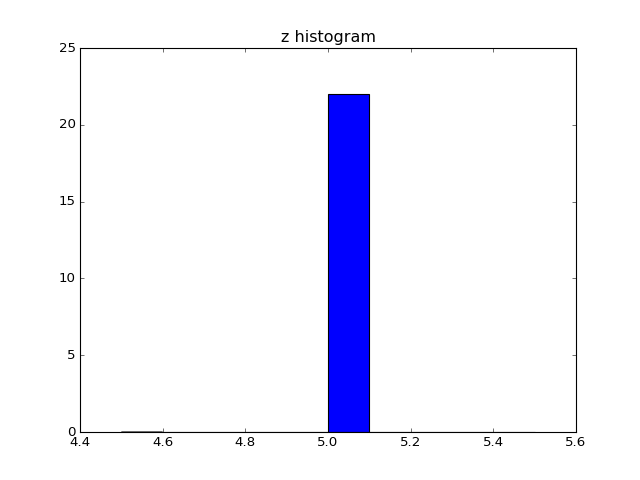


total outgoing edges
110


<IPython.core.display.Javascript object>


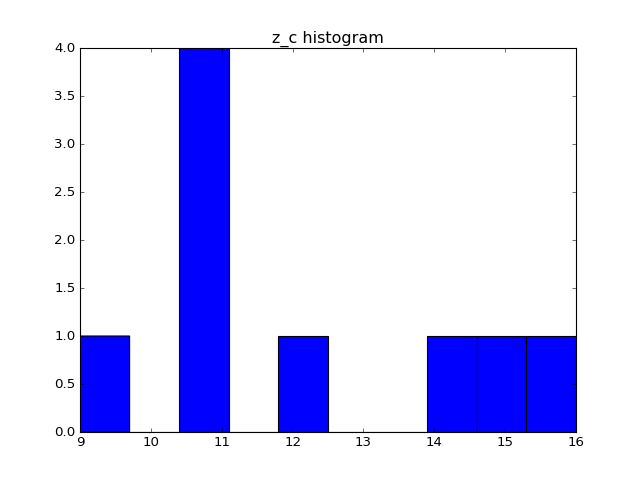


total incoming edges
110


In [4]:
# First define the input to constraint node connectivity

N = 22
print "N = %i" % N

N_c = int(5*N/12)
print "N_c = %i" % N_c

z = 5
print "z = %i" % z

z_c_avg = int(N*z/N_c)
print "z_c_avg = %i" % z_c_avg

M_max = 2**(z_c_avg-1)
print "M_max = %i" % M_max

r = 5
print "r = %i" % r

M_typical = 2**(z_c_avg-r)
print "M_typical = %i" % M_typical

input_to_constraint_node_connectivity = []
for i in range(N):
    input_to_constraint_node_connectivity.append(np.ndarray.tolist(np.random.choice(range(N_c), size = z, replace = False)))
    
constraint_node_to_input_connectivity = []
for i in range(N_c):
    temp = []
    for j in range(N):
        if i in input_to_constraint_node_connectivity[j]:
            temp.append(j)
    constraint_node_to_input_connectivity.append(temp)
    
plt.figure()
plt.title("z histogram")
plt.hist([len(q) for q in input_to_constraint_node_connectivity])
plt.show()

print "\ntotal outgoing edges"
print np.sum([len(q) for q in input_to_constraint_node_connectivity])

plt.figure()
plt.title("z_c histogram")
plt.hist([len(q) for q in constraint_node_to_input_connectivity])
plt.show()

print "\ntotal incoming edges"
print np.sum([len(q) for q in constraint_node_to_input_connectivity])

In [5]:
def generate_random_parity_states(input_size, num_parity_states_to_generate):
    parity_states = []
    for i in range(num_parity_states_to_generate):
        parity = 1
        state = []
        while parity == 1:
            state = np.random.randint(0,2,size = input_size)
            parity = sum(state) % 2
            if parity == 0:
                parity_states.append(state)

    return parity_states

print generate_random_parity_states(12, 1)

[array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0])]


In [6]:
def M_for_constraint_node(constraint_node_index):
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    return 2**(z_c_for_this_node - r)

In [7]:
def generate_constraint_node_neurons(constraint_node_index):
    neurons = []
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    M_for_this_node = M_for_constraint_node(constraint_node_index)
    for i in range(M_for_this_node):
        neuron = {}
        neuron["inputs"] = constraint_node_to_input_connectivity[constraint_node_index]
        neuron["num_inputs"] = len(neuron["inputs"])
        neuron["preferred_parity_config"] = generate_random_parity_states(neuron["num_inputs"], 1)[0]
        neuron["ones"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 1] 
        neuron["minus_ones"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 0]
        neuron["bias_term"] = z_c_avg - neuron["num_inputs"] # Is this the right interpretation of making all have equal total input?
        neurons.append(neuron)
    return neurons

print generate_constraint_node_neurons(N_c-1)[0]

{'inputs': [0, 1, 2, 4, 5, 6, 12, 15, 17, 18, 20], 'minus_ones': [1, 2, 4, 5, 15, 17, 18], 'num_inputs': 11, 'preferred_parity_config': array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]), 'ones': [0, 6, 12, 20], 'bias_term': 1}


In [8]:
def get_full_index(constraint_node_index, index_within_node):
    return N + sum([M_for_constraint_node(k) for k in range(constraint_node_index)]) + index_within_node

In [9]:
# Generating the full weight matrix and biases

last_constraint_node_index = N_c-1

last_neuron_in_last_constraint_node_index = M_for_constraint_node(last_constraint_node_index) - 1

total_number_neurons = get_full_index(last_constraint_node_index, last_neuron_in_last_constraint_node_index) + 2
total_number_neurons = int(total_number_neurons) # Not sure why it is making me do this
print "total number of neurons %i" % total_number_neurons
 
full_weight_matrix = [[0.0 for j in range(total_number_neurons)] for i in range(total_number_neurons)]

biases = [0.0 for j in range(total_number_neurons)]

for node in range(N_c): # Index over constraint nodes
    neurons_in_node = generate_constraint_node_neurons(node) # Generate neurons in that constraint node
    z_c_for_this_node = len(constraint_node_to_input_connectivity[node])
    M_for_this_node = M_for_constraint_node(node)
    for m in range(M_for_this_node):
        neuron_full_index = get_full_index(node, m)
        neuron = neurons_in_node[m]
        for g in neuron["ones"]: # constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = 1
            full_weight_matrix[g][neuron_full_index] = 1
        for g in neuron["minus_ones"]: # constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = -1
            full_weight_matrix[g][neuron_full_index] = -1
        for p in range(M_for_this_node): # inhibitory internal connectivity within the same node
            p_full_index = get_full_index(node, p)
            if p != m:
                full_weight_matrix[neuron_full_index][p_full_index] = -1*(neuron["num_inputs"] - 1)
                full_weight_matrix[p_full_index][neuron_full_index] =  -1*(neuron["num_inputs"] - 1)
        biases[neuron_full_index] = neuron["bias_term"]

total number of neurons 4007


<IPython.core.display.Javascript object>


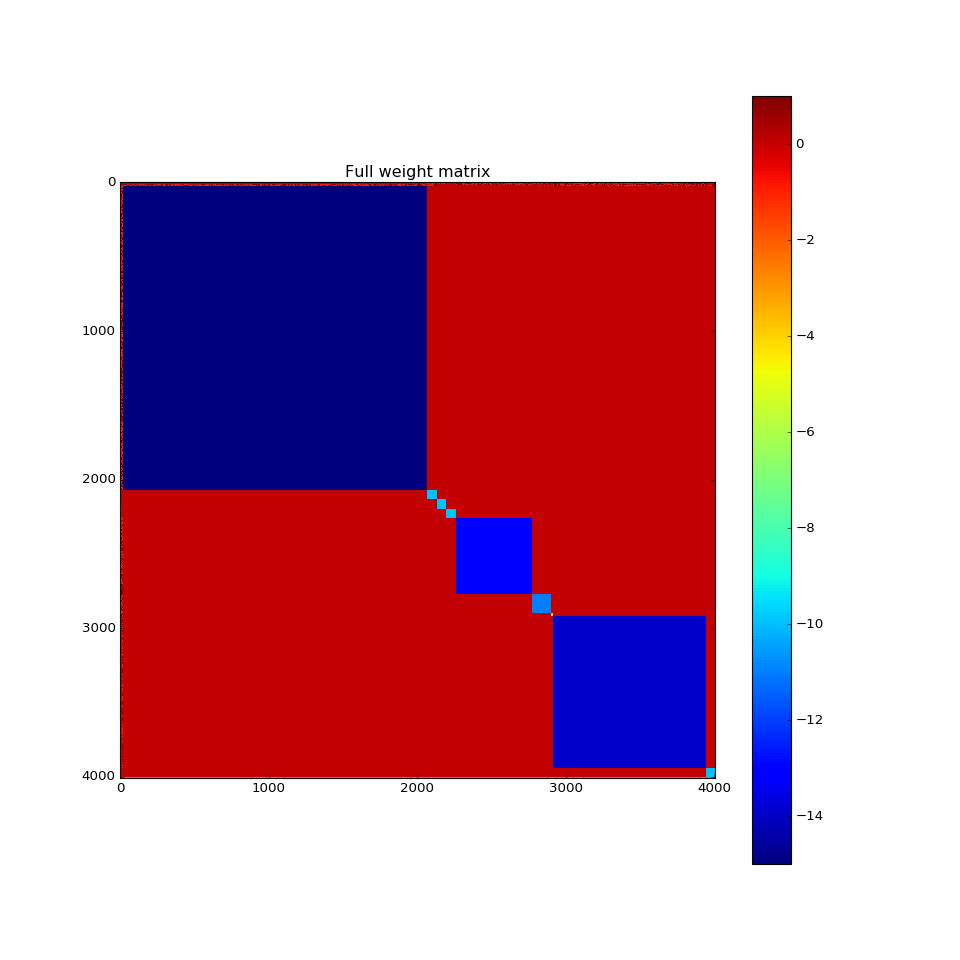

In [10]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.figure()
plt.title("Full weight matrix")
plt.imshow(full_weight_matrix, interpolation='none')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


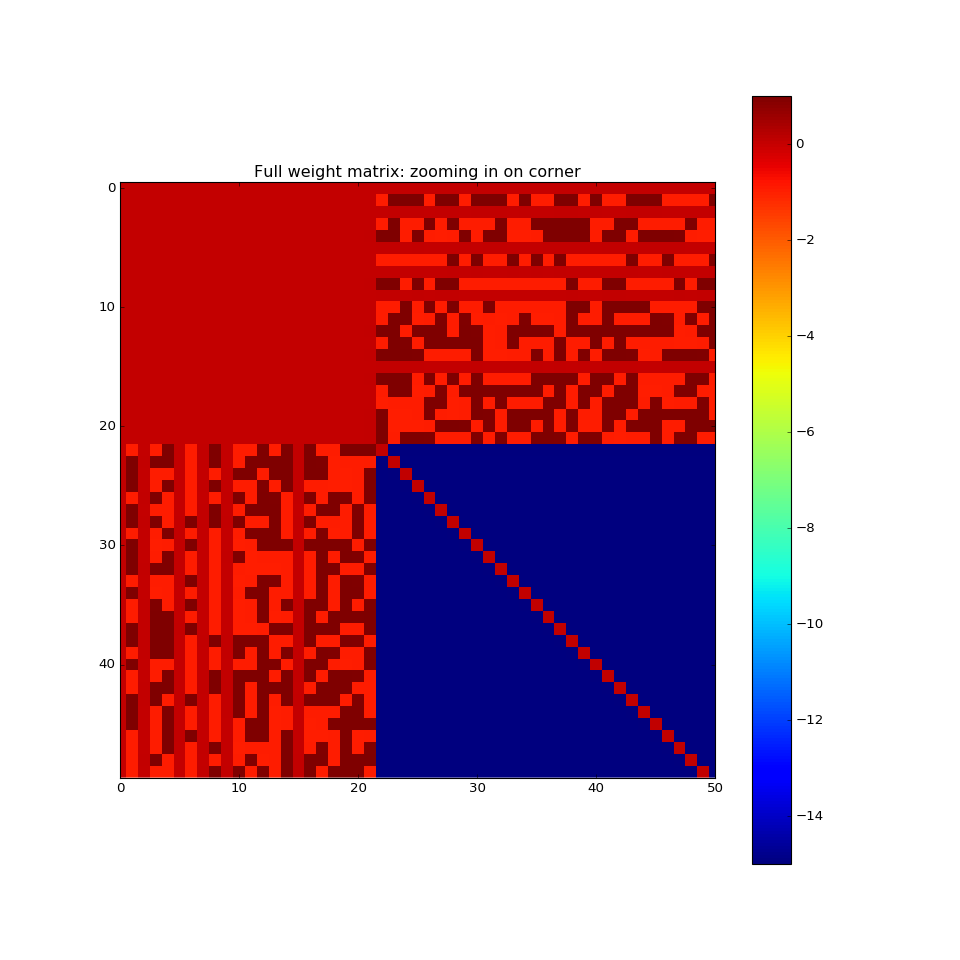

In [11]:
plt.figure()
plt.title("Full weight matrix: zooming in on corner")
corner = full_weight_matrix[:50][:50]
plt.imshow(corner, interpolation='none')
plt.xlim(0.0, 50.0)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


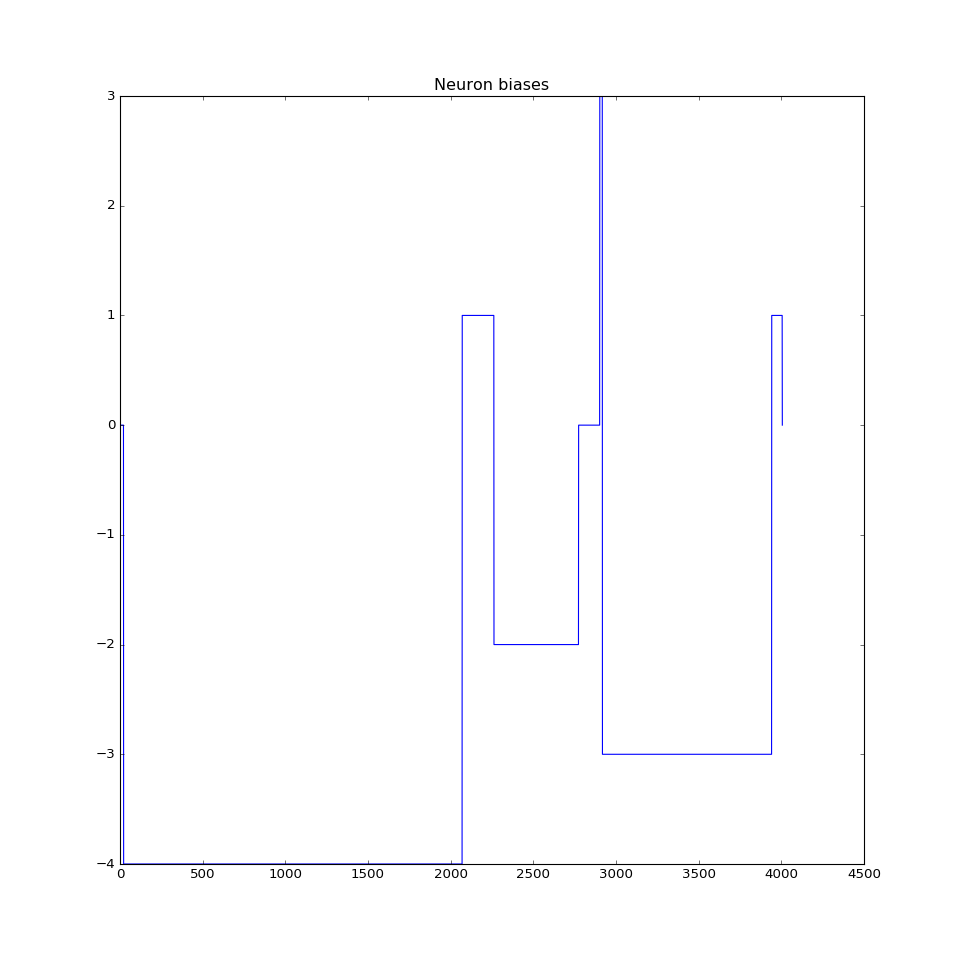

In [12]:
plt.figure()
plt.title("Neuron biases")
plt.plot(biases)
plt.show()

In [13]:
# Defining some Hopfield dynamics aspects

def random_state(num_neurons):
    neurons_binary_random = np.random.randint(0,2,size = num_neurons)
    neurons_plusminus_random = [(-1.0)**k for k in neurons_binary_random]
    return np.array(neurons_plusminus_random)

def time_step(state, weight_matrix, biases):
    new_state = []
    
    for k in range(len(state)):
        n = 0.0
        for j in range(len(state)):
            if j != k:
                n += weight_matrix[k][j] * state[j]
        n += biases[k]
        
        if n >= 0.0:
            new_state.append(1.0)
        else:
            new_state.append(-1.0)
            
    return new_state

def energy(s, weights, bias):
    x = np.array(s)
    W = np.array(weights)
    b = np.array(bias)
    E = -1 * (1/2) * np.matmul(np.matmul(np.transpose(x), W), x) - np.dot(x,b)
    return E 

In [14]:
initial_random_state = random_state(total_number_neurons)

num_timesteps = 20
state = initial_random_state
print energy(state, full_weight_matrix, biases)
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    print energy(new_state, full_weight_matrix, biases)
    print state[:10]
    state = new_state

238.0
-10320.0
[-1.  1. -1.  1. -1. -1. -1.  1.  1.  1.]
10320.0
[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0]
-10320.0
[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0]
10320.0
[-1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 